In [28]:
import os
import torch
import pandas as pd
import numpy as np
import seaborn as sns
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
%matplotlib inline

In [29]:
# Project name used for jovian.commit
project_name = '05-sport-classification'

## Exploring the sport image dataset

In [30]:
labels = {
    0: 'badminton',
    1: 'baseball',
    2: 'basketball',
    3: 'boxing',
    4: 'chess',
    5: 'cricket',
    6: 'fencing',
    7: 'football',
    8: 'formula1',
    9: 'gymnastics',
    10: 'hockey',
    11: 'ice_hockey',
    12: 'kabaddi',
    13: 'motogp',
    14: 'shooting',
    15: 'swimming',
    16: 'table_tennis',
    17: 'tennis',
    18: 'volleyball',
    19: 'weight_lifting',
    20: 'wrestling',
    21: 'wwe'
}

In [31]:
DATA_DIR = '../input/sports-image-dataset/input/data/'
DATA_CSV = '../input/sports-image-dataset/input/data.csv'

In [32]:
!head "{DATA_CSV}"

Store the dataset with labels into a dataframe

In [33]:
data_df = pd.read_csv(DATA_CSV)
data_df.head(5)

,image_path,target
0,../input/data/gymnastics/00000774.jpg,9.0
1,../input/data/table_tennis/00000702.jpg,16.0
2,../input/data/fencing/00000275.jpg,6.0
3,../input/data/baseball/00000380.jpg,1.0
4,../input/data/cricket/00000303.jpg,5.0


In [34]:
# number of classes in our dataset
len(data_df['target'].unique())

22

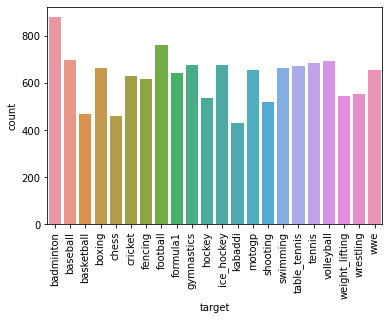

In [35]:
ax = sns.countplot(
    data_df['target'],
    
)
ax.set_xticklabels(labels.values(), rotation=90);

In [36]:
class SportsImageDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id, img_label = row['image_path'], row['target']
        img_fname = self.root_dir + "/" + img_id.split('/')[-2] + "/" + img_id.split('/')[-1]
        img = Image.open(img_fname)
        if self.transform:
            img = self.transform(img)
        return img, int(img_label)

In [37]:
np.random.RandomState(23)

RandomState(MT19937) at 0x7F3D5F390C00

In [38]:
train_df, val_df, test_df = np.split(data_df.sample(frac=1), [int(.8*len(data_df)), int(.9*len(data_df))])

len(train_df), len(val_df), len(test_df)

(11040, 1380, 1380)

In [39]:
train_df.reset_index(inplace=True)
val_df.reset_index(inplace=True)
test_df.reset_index(inplace=True)

In [40]:
stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
train_tfms = transforms.Compose(
    [
        transforms.Resize((72,72)),
        transforms.RandomCrop(64, padding=4, padding_mode='reflect'), 
        transforms.RandomHorizontalFlip(), 
        transforms.ToTensor(),
        transforms.RandomErasing(inplace=False), 
        transforms.Normalize(*stats,inplace=True)
    ]
)

valid_tfms = transforms.Compose(
    [
        transforms.Resize((64,64)),
        transforms.ToTensor(), 
        transforms.Normalize(*stats)
    ]
)

In [41]:
train_ds = SportsImageDataset(train_df, DATA_DIR, transform=train_tfms)
val_ds = SportsImageDataset(val_df, DATA_DIR, transform=valid_tfms)
test_ds = SportsImageDataset(test_df, DATA_DIR, transform=valid_tfms)

In [42]:
def show_sample(img, target, prediction= False, invert=True):
    print(img.shape)
    if invert:
        plt.imshow(1 - img.permute((1, 2, 0)))
    else:
        plt.imshow(img.permute(1, 2, 0))
    print('Label (numeric):', target)
    if not prediction:
        print('Label:', labels[target])

torch.Size([3, 64, 64])
Label (numeric): 15
Label: swimming


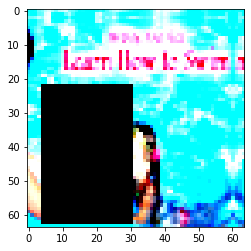

In [43]:
show_sample(*train_ds[13], invert=False)

In [44]:
torch.manual_seed(23)

In [45]:
batch_size = 32

In [46]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size*2, num_workers=4, pin_memory=True)

In [47]:
def show_batch(dl, invert=True):
    for images, labels in dl:
        print('images.shape:', images.shape)
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        data = 1-images if invert else images
        ax.imshow(make_grid(data, nrow=16).permute(1, 2, 0))
        break

images.shape: torch.Size([32, 3, 64, 64])


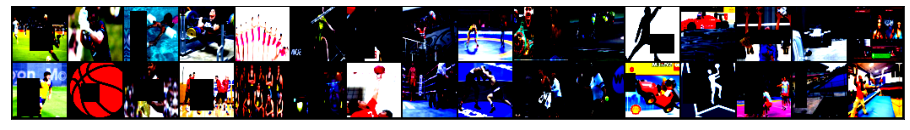

In [48]:
show_batch(train_loader, False)

images.shape: torch.Size([64, 3, 64, 64])


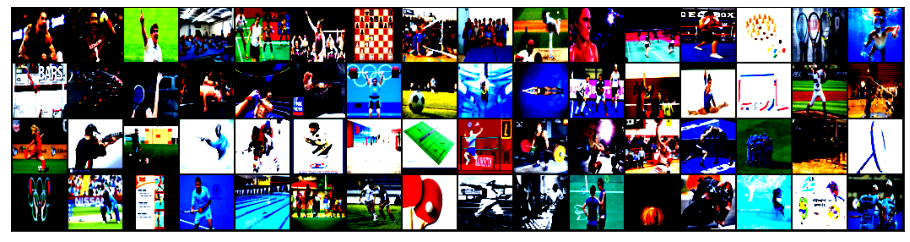

In [49]:
show_batch(val_loader, False)

images.shape: torch.Size([64, 3, 64, 64])


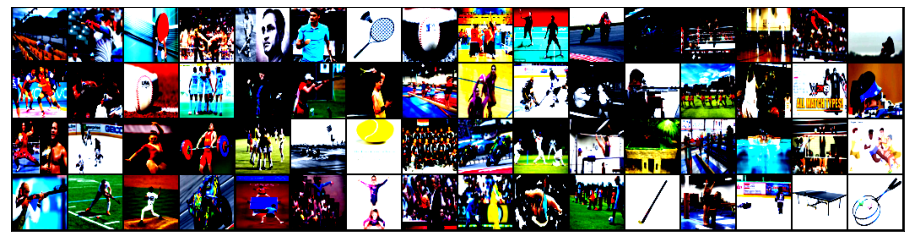

In [50]:
show_batch(test_loader, False)

In [51]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [52]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [53]:
class SportsImageLinearModel(ImageClassificationBase):
    def __init__(self, output_size):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),

            nn.Flatten(), 
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_size)
        )
        
    def forward(self, xb):
        return self.network(xb)


In [54]:
class SportsImageLinearModel(ImageClassificationBase):
    def __init__(self, output_size):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, output_size)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    
    def freeze(self):
        # to freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        
        # only train the last layer
        for param in self.network.fc.parameters():
            param.require_grad = True
            
    def unfreeze(self):
        for param in self.network.parameters():
            param.require_grad = True

In [55]:
input_size = 3*64*64
output_size = 22

In [56]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [57]:
device = get_default_device()
device

device(type='cuda')

In [58]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
model = to_device(SportsImageLinearModel(output_size), device)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [59]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [60]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 3.1022040843963623, 'val_acc': 0.0607638917863369}]

In [61]:
epochs = 10
max_lr = 0.0001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [62]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], train_loss: 3.0170, val_loss: 2.8564, val_acc: 0.3099
Epoch [1], train_loss: 2.7034, val_loss: 2.5408, val_acc: 0.5657
Epoch [2], train_loss: 2.5099, val_loss: 2.4348, val_acc: 0.6414
Epoch [3], train_loss: 2.4398, val_loss: 2.3961, val_acc: 0.6954
Epoch [4], train_loss: 2.4035, val_loss: 2.3765, val_acc: 0.7013
Epoch [5], train_loss: 2.3670, val_loss: 2.3605, val_acc: 0.7354
Epoch [6], train_loss: 2.3386, val_loss: 2.3542, val_acc: 0.7384
Epoch [7], train_loss: 2.3226, val_loss: 2.3458, val_acc: 0.7448
Epoch [8], train_loss: 2.3053, val_loss: 2.3421, val_acc: 0.7517
Epoch [9], train_loss: 2.2989, val_loss: 2.3424, val_acc: 0.7510
CPU times: user 2min 46s, sys: 6.48 s, total: 2min 53s
Wall time: 17min 7s


In [63]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

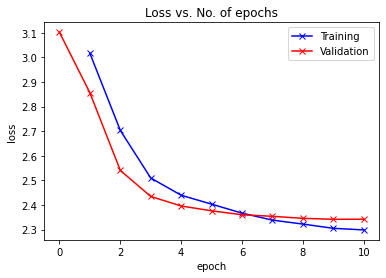

In [64]:
plot_losses(history)

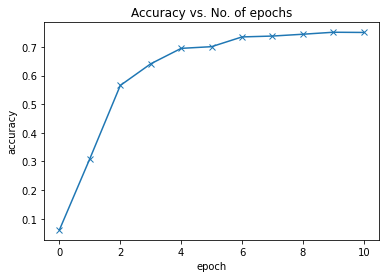

In [65]:
plot_accuracies(history)

In [66]:
def try_batch(dl):
    for images, labels in dl:
        print('images.shape:', images.shape)
        out = model(images)
        print('out.shape:', out.shape)
        print('out[0]:', out[0])
        _, preds = torch.max(out, dim=1)
        print(labels)
        print(preds)
        break

try_batch(train_loader)

images.shape: torch.Size([32, 3, 64, 64])
out.shape: torch.Size([32, 22])
out[0]: tensor([0.1148, 0.0508, 0.0085, 0.0061, 0.1756, 0.2069, 0.8435, 0.6028, 0.0037,
        0.7068, 0.4291, 0.3077, 0.0433, 0.0091, 0.8356, 0.0032, 0.0343, 0.0290,
        0.0073, 0.1466, 0.0248, 0.0692], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([ 5, 18, 21, 12, 18,  5, 15,  3,  7,  5, 14,  6,  9,  0,  2, 14,  6,  9,
        12,  9, 19,  0, 14,  7, 11, 19,  8,  6,  6,  1, 21, 16],
       device='cuda:0')
tensor([ 6, 18, 21, 10, 18,  5, 15,  3,  7,  5, 14,  6,  9,  0,  3, 21,  6,  9,
        12,  9, 19,  0, 14,  7, 11, 19,  8,  6,  6,  1, 21, 16],
       device='cuda:0')


In [67]:
test_loader = DeviceDataLoader(test_loader, device)
eval_test = evaluate(model, test_loader)
eval_test

{'val_loss': 2.35367751121521, 'val_acc': 0.7402145862579346}

In [68]:
def predict_single(image):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    print("Prediction: ", prediction)
    _, preds = torch.max(prediction, dim=0)
    show_sample(image, preds.item(), prediction=False, invert=False)

Prediction:  tensor([1.5478e-02, 1.2257e-01, 3.4045e-03, 2.0141e-01, 6.8938e-01, 1.0091e-02,
        9.7331e-01, 2.3298e-02, 8.9343e-01, 2.4240e-03, 6.8152e-03, 3.5498e-01,
        1.1601e-02, 4.7395e-03, 7.2070e-04, 8.7258e-03, 5.2792e-03, 5.3606e-03,
        9.7384e-04, 4.6420e-03, 9.5138e-03, 4.5035e-03], device='cuda:0',
       grad_fn=<SelectBackward>)
torch.Size([3, 64, 64])
Label (numeric): 6
Label: fencing


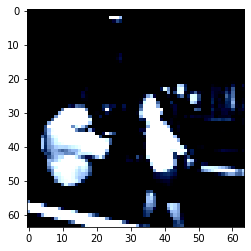

In [69]:
predict_single(test_ds[26][0])

In [70]:
arch = "resnet34"
preprocessing = "resize,crop,horizontalflip,erase,normalize"
test_acc = eval_test["val_acc"]
test_loss = eval_test["val_loss"]

In [71]:
torch.save(model.state_dict(), 'sports-image-model.pth')

In [75]:
# Clear previously recorded hyperparams & metrics
jovian.reset()
jovian.log_hyperparams(preprocessing = preprocessing,
                       arch=arch, 
                       epochs = epochs,
                       max_lr= max_lr,
                       grad_clip=grad_clip,
                       weight_decay= weight_decay,
                       opt_func = "torch.optim.Adam")
jovian.log_metrics(test_loss=test_loss, test_acc=test_acc)
jovian.commit(project=project_name, outputs=['sports-image-model.pth'], environment=None)

[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Hyperparams logged.
[jovian] Metrics logged.


<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/benrallet/05-sport-classification


<IPython.core.display.Javascript object>

In [73]:
!pip install jovian --upgrade

     |████████████████████████████████| 63 kB 1.0 MB/s eta 0:00:011
  Created wheel for uuid: filename=uuid-1.30-py3-none-any.whl size=6500 sha256=951d4b7985fda2f7d9c619cf982b666ab18a8d9dd37e7c96ca99bf390f38ef3e
  Stored in directory: /root/.cache/pip/wheels/2a/ea/87/dd57f1ecb4f0752f3e1dbf958ebf8b36d920d190425bcdc24d
Successfully built uuid


In [74]:
import jovian

<IPython.core.display.Javascript object>